In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00


**Designing a simulation for 2 atoms**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Constants -
sigma = 0.34  # nm (Lennard-Jones distance parameter)
epsilon = 120 * 1.38e-23  # J (Lennard-Jones energy parameter)
mass = 39.948 * 1.66e-27  # kg (Argon atomic mass)
kb = 1.38e-23  # J/K (Boltzmann constant)
dt = 5e-15  # s (Time step)
num_steps = 1000000  # Total simulation steps

# Compute box size so that its diagonal is equal to the cutoff distance
cutoff = 0.5
box_size = cutoff / np.sqrt(3)  # Cube with diagonal = cutoff distance

# Initialize Positions & Velocities

np.random.seed(42)  # For reproducibility

# First atom's initial position
position1 = np.random.uniform(0, box_size, (3,))

# Second atom placed **very close** to the first atom
position2 = position1 + np.random.uniform(0.01, 0.02, (3,))  # Almost overlapping

# Apply PBCs in case the second atom is outside the box
position2 = position2 % box_size

# Initial velocities from Maxwell-Boltzmann distribution
temperature = 300  # K
std_dev = np.sqrt(kb * temperature / mass)
velocity1 = np.random.normal(0, std_dev, (3,)) * 10  # Scaling up velocity
velocity2 = np.random.normal(0, std_dev, (3,)) * 10

# Store trajectories
positions1_list = [position1.copy()]
positions2_list = [position2.copy()]
velocity1_list = [velocity1.copy()]
velocity2_list = [velocity2.copy()]

#Define Functions

def minimum_image_distance(r1, r2, box_size):
    """Compute the shortest distance between two atoms using the Minimum Image Convention."""
    delta_r = r1 - r2
    delta_r -= box_size * np.round(delta_r / box_size)  # Apply PBC
    return delta_r, np.linalg.norm(delta_r)

def lennard_jones_force(r1, r2, box_size):
    """Compute the Lennard-Jones force using the minimum image convention."""
    delta_r, r = minimum_image_distance(r1, r2, box_size)

    if r > cutoff:  # Apply cutoff to reduce computation
        return np.zeros(3), np.zeros(3)

    force_mag = 24 * epsilon * (2 * (sigma / r) ** 12 - (sigma / r) ** 6) / r ** 2
    force = force_mag * delta_r / r
    return force, -force  # Newton's third law: F_1 = -F_2

#Run MD Simulation with Lennard-Jones Forces

for step in range(num_steps):
    # Compute forces
    force1, force2 = lennard_jones_force(position1, position2, box_size)

    # Update positions (Velocity Verlet)
    new_position1 = position1 + velocity1 * dt + 0.5 * (force1 / mass) * dt ** 2
    new_position2 = position2 + velocity2 * dt + 0.5 * (force2 / mass) * dt ** 2

    # Apply Periodic Boundary Conditions (PBCs)
    new_position1 = new_position1 % box_size
    new_position2 = new_position2 % box_size

    # Recompute forces at new positions
    new_force1, new_force2 = lennard_jones_force(new_position1, new_position2, box_size)

    # Update velocities (Velocity Verlet)
    velocity1 += 0.5 * (force1 + new_force1) / mass * dt
    velocity2 += 0.5 * (force2 + new_force2) / mass * dt

    # Store new positions
    positions1_list.append(new_position1.copy())
    positions2_list.append(new_position2.copy())
    velocity1_list.append(velocity1.copy())
    velocity2_list.append(velocity2.copy())

    # Update position references for next iteration
    position1 = new_position1
    position2 = new_position2

# Convert to numpy arrays for visualization
positions1_array = np.array(positions1_list)
positions2_array = np.array(positions2_list)
velocity1_array = np.array(velocity1_list)
velocity2_array = np.array(velocity2_list)

#Visualization with Slider

def plot_trajectory(max_timestep):
    step_size = 10  # Reduce number of points for clarity
    selected_positions1 = positions1_array[:max_timestep:step_size]
    selected_positions2 = positions2_array[:max_timestep:step_size]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Atom 1
    ax.plot(selected_positions1[:, 0], selected_positions1[:, 1], selected_positions1[:, 2],
            marker='o', linestyle='-', color='blue', label="Atom 1 Path")

    # Plot Atom 2
    ax.plot(selected_positions2[:, 0], selected_positions2[:, 1], selected_positions2[:, 2],
            marker='o', linestyle='-', color='red', label="Atom 2 Path")

    # Initial positions
    ax.scatter(selected_positions1[0, 0], selected_positions1[0, 1], selected_positions1[0, 2],
               c='b', marker='o', label="Start Atom 1")
    ax.scatter(selected_positions2[0, 0], selected_positions2[0, 1], selected_positions2[0, 2],
               c='r', marker='o', label="Start Atom 2")

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)
    ax.set_xlabel("X Position (nm)")
    ax.set_ylabel("Y Position (nm)")
    ax.set_zlabel("Z Position (nm)")
    ax.set_title(f"Trajectory of Two Argon Atoms (0 to {max_timestep})")
    ax.legend()
    plt.show()

# Interactive Slider
interact(plot_trajectory, max_timestep=IntSlider(min=10, max=num_steps, step=10, value=100));

interactive(children=(IntSlider(value=100, description='max_timestep', max=1000000, min=10, step=10), Output()…

**Calculation of Total Energy as a Sanity check**

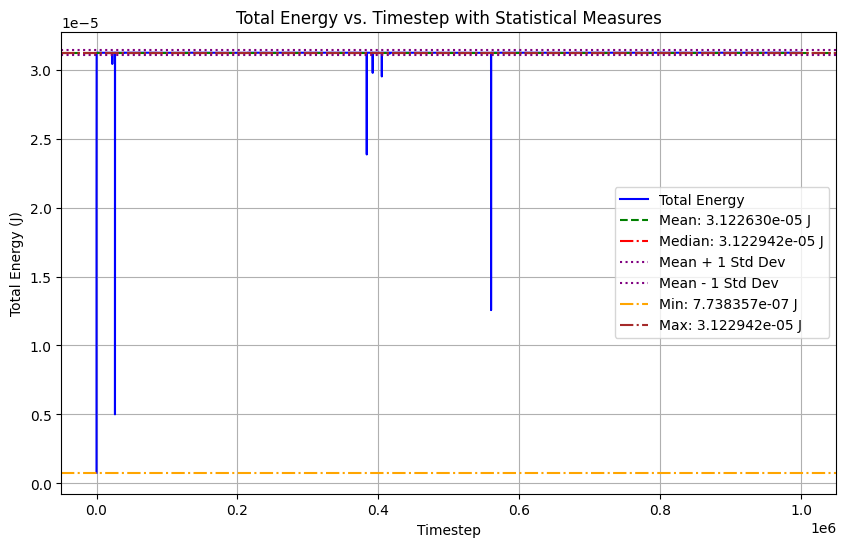

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_energy_statistics(energy_per_timestep):
    """
    Plots the total energy vs. timestep with mean, median, and standard deviation.

    Args:
        energy_per_timestep (numpy.ndarray): Array of total energy values for each timestep.
    """
    # Compute statistics
    mean_energy = np.mean(energy_per_timestep)
    median_energy = np.median(energy_per_timestep)
    std_dev_energy = np.std(energy_per_timestep)
    min_energy = np.min(energy_per_timestep)
    max_energy = np.max(energy_per_timestep)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot total energy
    plt.plot(range(len(energy_per_timestep)), energy_per_timestep, label="Total Energy", color="blue")

    # Plot statistics as horizontal lines
    plt.axhline(mean_energy, color='green', linestyle='--', label=f"Mean: {mean_energy:.6e} J")
    plt.axhline(median_energy, color='red', linestyle='-.', label=f"Median: {median_energy:.6e} J")
    plt.axhline(mean_energy + std_dev_energy, color='purple', linestyle=':', label=f"Mean + 1 Std Dev")
    plt.axhline(mean_energy - std_dev_energy, color='purple', linestyle=':', label=f"Mean - 1 Std Dev")
    plt.axhline(min_energy, color='orange', linestyle='-.', label=f"Min: {min_energy:.6e} J")
    plt.axhline(max_energy, color='brown', linestyle='-.', label=f"Max: {max_energy:.6e} J")

    # Labels and title
    plt.xlabel("Timestep")
    plt.ylabel("Total Energy (J)")
    plt.title("Total Energy vs. Timestep with Statistical Measures")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Example Usage (Call this function after computing `energy_per_timestep`)
plot_energy_statistics(energy_per_timestep)

**Plotting the trajectories individually**

In [ ]:
def plot_atom_trajectories(max_timestep):
    """Plot the individual trajectories of Atom 1 and Atom 2 up to the selected timestep."""
    step_size = 1  # Increase sensitivity by reducing step size
    selected_positions1 = positions1_array[:max_timestep:step_size]
    selected_positions2 = positions2_array[:max_timestep:step_size]

    fig = plt.figure(figsize=(14, 6))

    # Plot for Atom 1
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(selected_positions1[:, 0], selected_positions1[:, 1], selected_positions1[:, 2],
             marker='o', linestyle='-', color='blue', label="Atom 1 Path")
    ax1.scatter(selected_positions1[0, 0], selected_positions1[0, 1], selected_positions1[0, 2],
                c='b', marker='o', label="Start Atom 1")
    ax1.set_xlim(0, box_size)
    ax1.set_ylim(0, box_size)
    ax1.set_zlim(0, box_size)
    ax1.set_xlabel("X Position (nm)")
    ax1.set_ylabel("Y Position (nm)")
    ax1.set_zlabel("Z Position (nm)")
    ax1.set_title(f"Trajectory of Atom 1 (0 to {max_timestep})")
    ax1.legend()

    # Plot for Atom 2
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(selected_positions2[:, 0], selected_positions2[:, 1], selected_positions2[:, 2],
             marker='o', linestyle='-', color='red', label="Atom 2 Path")
    ax2.scatter(selected_positions2[0, 0], selected_positions2[0, 1], selected_positions2[0, 2],
                c='r', marker='o', label="Start Atom 2")
    ax2.set_xlim(0, box_size)
    ax2.set_ylim(0, box_size)
    ax2.set_zlim(0, box_size)
    ax2.set_xlabel("X Position (nm)")
    ax2.set_ylabel("Y Position (nm)")
    ax2.set_zlabel("Z Position (nm)")
    ax2.set_title(f"Trajectory of Atom 2 (0 to {max_timestep})")
    ax2.legend()

    plt.show()

# Interactive Slider (longer range & higher sensitivity)
interact(plot_atom_trajectories, max_timestep=IntSlider(min=1, max=num_steps, step=1, value=100));

interactive(children=(IntSlider(value=100, description='max_timestep', max=1000000, min=1), Output()), _dom_cl…

**Measuring time taken by verlet compared to neural network**

In [ ]:
import time
import numpy as np

def measure_timestep_time():

    # Re-initialize positions and velocities
    position1 = np.random.uniform(0, box_size, (3,))
    position2 = position1 + np.random.uniform(0.01, 0.02, (3,))  # Almost overlapping
    position2 = position2 % box_size  # Apply PBC
    total_standard_time = 0

    velocity1 = np.random.normal(0, std_dev, (3,)) * 10
    velocity2 = np.random.normal(0, std_dev, (3,)) * 10

    # Start time measurement
    for i in range(10000):
      start_time = time.time()

      # Compute forces
      force1, force2 = lennard_jones_force(position1, position2, box_size)

      # Update positions (Velocity Verlet)
      new_position1 = position1 + velocity1 * dt + 0.5 * (force1 / mass) * dt ** 2
      new_position2 = position2 + velocity2 * dt + 0.5 * (force2 / mass) * dt ** 2
      new_position1 = new_position1 % box_size  # Apply PBC
      new_position2 = new_position2 % box_size  # Apply PBC

      # Recompute forces at new positions
      new_force1, new_force2 = lennard_jones_force(new_position1, new_position2, box_size)

      # Update velocities (Velocity Verlet)
      velocity1 += 0.5 * (force1 + new_force1) / mass * dt
      velocity2 += 0.5 * (force2 + new_force2) / mass * dt

      # End time measurement
      end_time = time.time()
      total_standard_time = total_standard_time + (end_time - start_time)

    # Compute elapsed time
    timestep_time = total_standard_time / 1000
    print(f"Time taken for one timestep: {timestep_time:.6f} seconds")

# Run the function
measure_timestep_time()

Time taken for one timestep: 0.000485 seconds


In [ ]:
import torch
import torch.nn as nn

# Define the balanced architecture (32 neurons per hidden layer, 2 hidden layers)
class MDNeuralNet(nn.Module):
    def __init__(self, input_size=12, hidden_size=64, output_size=12):
        super(MDNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on the output layer
        return x

# Initialize the model
model = MDNeuralNet()

# Move model to GPU if available for faster computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MDNeuralNet(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=12, bias=True)
)

In [ ]:
import time

# Generate a random input tensor (12 features)
input_tensor = torch.randn(1, 12).to(device)
total_nn_time = 0

# Measure inference time
for i in range(10000):  # Run the loop 10 times
  start_time = time.time()
  output = model(input_tensor)
  end_time = time.time()
  nn_time = end_time - start_time
  total_nn_time = total_nn_time + nn_time

# Compute average inference time
avg_nn_time = total_nn_time / 1000

print(f"Neural Network Inference Time: {avg_nn_time:.6f} seconds")

Neural Network Inference Time: 0.000507 seconds


In [ ]:
import numpy as np

def remove_pbc_crossings(positions1_array, positions2_array, box_size):

    # Identify crossings: when an atom moves from one side of the box to the other
    crossings = (
        (np.abs(np.diff(positions1_array, axis=0)) > box_size / 2).any(axis=1) |
        (np.abs(np.diff(positions2_array, axis=0)) > box_size / 2).any(axis=1)
    )

    # Count occurrences of PBC crossings
    num_crossings = np.sum(crossings)

    # Keep only the non-crossing indices
    valid_indices = np.where(~crossings)[0]  # Indices of valid time steps

    # Apply filtering to ensure both arrays have the same time steps
    filtered_positions1 = positions1_array[valid_indices]
    filtered_positions2 = positions2_array[valid_indices]

    print(f"Removed {num_crossings} timesteps due to periodic boundary crossings.")
    print(f"Remaining valid timesteps: {len(filtered_positions1)}")

    return filtered_positions1, filtered_positions2


# Call function to remove PBC crossings
filtered_positions1, filtered_positions2 = remove_pbc_crossings(positions1_array, positions2_array, box_size)

Removed 669 timesteps due to periodic boundary crossings.
Remaining valid timesteps: 999331


In [ ]:
def plot_atom_trajectories(max_timestep):
    """Plot the individual trajectories of Atom 1 and Atom 2 up to the selected timestep."""
    step_size = 1  # Increase sensitivity by reducing step size
    selected_positions1 = filtered_positions1[:max_timestep:step_size]
    selected_positions2 = filtered_positions2[:max_timestep:step_size]

    fig = plt.figure(figsize=(14, 6))

    # Plot for Atom 1
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(selected_positions1[:, 0], selected_positions1[:, 1], selected_positions1[:, 2],
             marker='o', linestyle='-', color='blue', label="Atom 1 Path")
    ax1.scatter(selected_positions1[0, 0], selected_positions1[0, 1], selected_positions1[0, 2],
                c='b', marker='o', label="Start Atom 1")
    ax1.set_xlim(0, box_size)
    ax1.set_ylim(0, box_size)
    ax1.set_zlim(0, box_size)
    ax1.set_xlabel("X Position (nm)")
    ax1.set_ylabel("Y Position (nm)")
    ax1.set_zlabel("Z Position (nm)")
    ax1.set_title(f"Trajectory of Atom 1 (0 to {max_timestep})")
    ax1.legend()

    # Plot for Atom 2
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(selected_positions2[:, 0], selected_positions2[:, 1], selected_positions2[:, 2],
             marker='o', linestyle='-', color='red', label="Atom 2 Path")
    ax2.scatter(selected_positions2[0, 0], selected_positions2[0, 1], selected_positions2[0, 2],
                c='r', marker='o', label="Start Atom 2")
    ax2.set_xlim(0, box_size)
    ax2.set_ylim(0, box_size)
    ax2.set_zlim(0, box_size)
    ax2.set_xlabel("X Position (nm)")
    ax2.set_ylabel("Y Position (nm)")
    ax2.set_zlabel("Z Position (nm)")
    ax2.set_title(f"Trajectory of Atom 2 (0 to {max_timestep})")
    ax2.legend()
    plt.show()

# Interactive Slider (longer range & higher sensitivity)
interact(plot_atom_trajectories, max_timestep=IntSlider(min=1, max=num_steps, step=1, value=100));

interactive(children=(IntSlider(value=100, description='max_timestep', max=1000000, min=1), Output()), _dom_cl…

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

dtype = torch.float16

# Stack position and velocity arrays to create input (X) and output (Y) datasets
X = np.hstack([positions1_array[:-1], positions2_array[:-1], velocity1_array[:-1], velocity2_array[:-1]])
Y = np.hstack([positions1_array[1:], positions2_array[1:], velocity1_array[1:], velocity2_array[1:]])

# Free up memory
del positions1_array, positions2_array, velocity1_array, velocity2_array

# Split into 75% train and 25% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Free up memory
del X, Y

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=dtype)
Y_train_tensor = torch.tensor(Y_train, dtype=dtype)
X_test_tensor = torch.tensor(X_test, dtype=dtype)
Y_test_tensor = torch.tensor(Y_test, dtype=dtype)

# Free up memory
del X_train, Y_train, X_test, Y_test


class MDNeuralNet(nn.Module):
    def __init__(self, input_size=12, hidden_size=64, output_size=12):
        super(MDNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MDNeuralNet(input_size=X_train_tensor.shape[1], output_size=Y_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_tensor, Y_train_tensor = X_train_tensor.to(device), Y_train_tensor.to(device)
X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)

num_epochs = 20
batch_size = 64  # Smaller batch size to save memory
train_losses = []

# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6e}")

RuntimeError: mat1 and mat2 must have the same dtype, but got Half and Float

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dtype = torch.float32  # Ensure all tensors use float32

# Stack position and velocity arrays to create input (X) and output (Y) datasets
X = np.hstack([positions1_array[:-1], positions2_array[:-1], velocity1_array[:-1], velocity2_array[:-1]])
Y = np.hstack([positions1_array[1:], positions2_array[1:], velocity1_array[1:], velocity2_array[1:]])

# Normalize using Min-Max Scaling
scaler_X = MinMaxScaler(feature_range=(-1, 1))  # Scale to [-1, 1] for stable training
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Free up memory
#del positions1_array, positions2_array, velocity1_array, velocity2_array

# Split into 75% train and 25% test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=42)

# Free up memory
del X, Y

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Free up memory
del X_train, Y_train, X_test, Y_test


class MDNeuralNet(nn.Module):
    def __init__(self, input_size=12, hidden_size=64, output_size=12):
        super(MDNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.float()  # Ensure input is float32
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MDNeuralNet(input_size=X_train_tensor.shape[1], output_size=Y_train_tensor.shape[1]).to(device).float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_tensor, Y_train_tensor = X_train_tensor.to(device), Y_train_tensor.to(device)
X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)


num_epochs = 20
batch_size = 64  # Keep small to avoid memory overload
train_losses = []

# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6e}")


model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, Y_test_tensor).item()

print(f"\nTest Loss: {test_loss:.6e}")

NameError: name 'positions1_array' is not defined

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


model.eval()
errors = []

batch_size = 10000  # Process test data in smaller batches to avoid memory spikes
num_batches = len(X_test_tensor) // batch_size + 1

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test_tensor))

    with torch.no_grad():
        test_outputs_batch = model(X_test_tensor[start_idx:end_idx].to(device)).cpu()
        errors_batch = torch.mean(torch.abs(test_outputs_batch - Y_test_tensor[start_idx:end_idx].cpu()), dim=1).numpy()
        errors.extend(errors_batch)

# Convert errors to NumPy array for indexing
errors = np.array(errors)

# Find best, worst, and average case indices
best_idx = np.argmin(errors)
worst_idx = np.argmax(errors)
avg_idx = np.argmin(np.abs(errors - np.mean(errors)))  # Closest to mean error


def plot_comparison(idx, title):
    """Plots predicted vs ground truth positions and velocities for a given test sample."""
    with torch.no_grad():
        ground_truth = Y_test_tensor[idx].cpu().numpy()
        prediction = model(X_test_tensor[idx].unsqueeze(0).to(device)).cpu().numpy().flatten()

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(ground_truth)), ground_truth, label="Ground Truth", linestyle="-", marker="o", color="blue")
    plt.plot(range(len(prediction)), prediction, label="Predicted", linestyle="--", marker="x", color="red")
    plt.xlabel("Feature Index (Position & Velocity Components)")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Best, Average, and Worst Cases
plot_comparison(best_idx, "Best Case: Predicted vs Ground Truth")
plot_comparison(avg_idx, "Average Case: Predicted vs Ground Truth")
plot_comparison(worst_idx, "Worst Case: Predicted vs Ground Truth")


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def plot_separate_trajectories(idx, case_name):
    """Creates 6 separate 3D plots: Predicted and Ground Truth for both atoms."""

    num_timesteps = 10  # Predict 10 steps ahead

    # Extract ground truth trajectory for 10 timesteps
    ground_truth_positions1 = Y_test_tensor[idx:idx + num_timesteps, :3].cpu().numpy()
    ground_truth_positions2 = Y_test_tensor[idx:idx + num_timesteps, 3:6].cpu().numpy()

    # Store predicted positions
    predicted_positions1 = []
    predicted_positions2 = []

    # Initialize with first input state
    input_state = X_test_tensor[idx].unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(num_timesteps):
            prediction = model(input_state).cpu().numpy().flatten()

            # Store predicted positions
            predicted_positions1.append(prediction[:3])
            predicted_positions2.append(prediction[3:6])

            # Update input state with new prediction
            input_state = torch.tensor(prediction, dtype=torch.float32).unsqueeze(0).to(device)

    # Convert lists to NumPy arrays for plotting
    predicted_positions1 = np.array(predicted_positions1)
    predicted_positions2 = np.array(predicted_positions2)

    # Create 6 subplots: Predicted & Ground Truth for Atom 1 & Atom 2
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': '3d'})

    # Plot Predicted for Atom 1
    axes[0, 0].plot(predicted_positions1[:, 0], predicted_positions1[:, 1], predicted_positions1[:, 2],
                     'b--', label="Atom 1 Predicted")
    axes[0, 0].set_title(f"{case_name} - Atom 1 Predicted")
    axes[0, 0].set_xlabel("X Position")
    axes[0, 0].set_ylabel("Y Position")
    axes[0, 0].set_zlabel("Z Position")
    axes[0, 0].legend()

    # Plot Ground Truth for Atom 1
    axes[0, 1].plot(ground_truth_positions1[:, 0], ground_truth_positions1[:, 1], ground_truth_positions1[:, 2],
                     'b-', label="Atom 1 Ground Truth")
    axes[0, 1].set_title(f"{case_name} - Atom 1 Ground Truth")
    axes[0, 1].set_xlabel("X Position")
    axes[0, 1].set_ylabel("Y Position")
    axes[0, 1].set_zlabel("Z Position")
    axes[0, 1].legend()

    # Empty subplot for spacing
    axes[0, 2].axis('off')

    # Plot Predicted for Atom 2
    axes[1, 0].plot(predicted_positions2[:, 0], predicted_positions2[:, 1], predicted_positions2[:, 2],
                     'g--', label="Atom 2 Predicted")
    axes[1, 0].set_title(f"{case_name} - Atom 2 Predicted")
    axes[1, 0].set_xlabel("X Position")
    axes[1, 0].set_ylabel("Y Position")
    axes[1, 0].set_zlabel("Z Position")
    axes[1, 0].legend()

    # Plot Ground Truth for Atom 2
    axes[1, 1].plot(ground_truth_positions2[:, 0], ground_truth_positions2[:, 1], ground_truth_positions2[:, 2],
                     'g-', label="Atom 2 Ground Truth")
    axes[1, 1].set_title(f"{case_name} - Atom 2 Ground Truth")
    axes[1, 1].set_xlabel("X Position")
    axes[1, 1].set_ylabel("Y Position")
    axes[1, 1].set_zlabel("Z Position")
    axes[1, 1].legend()

    # Empty subplot for spacing
    axes[1, 2].axis('off')

    plt.show()

plot_separate_trajectories(best_idx, "Best Case")
plot_separate_trajectories(avg_idx, "Average Case")
plot_separate_trajectories(worst_idx, "Worst Case")
